# Simulate an artificial image

The goal of this notebook is to simulate an artificial image of a star field at RA=280 deg, Dec=0 deg. This will familiarize you with the data generating process of an astronomical image, especially help you understand how do bias, dark, read-out noise, and sky background affect the final image. At the end of this notebook, you will play with an interactive tool to simulate a realistic image of any given exposure time, sky background, read-out noise, bias value, dark current, and seeing condition. Have fun!

**Prerequisites**
- Basic statistics
- Knowledge about CCD, bias, dark, and flat frames
- Finished the "Calibration frame" notebook

**We will learn**
- Understand the [data generating process](https://en.wikipedia.org/wiki/Data_generating_process) of an astronomical image
- Point Spread Function and 2-D Gaussian function
- World Coordinate System (WCS) and how to convert (RA, DEC) on the sky to (x, y) on the image
- How to write docstrings for your functions

In [1]:
%matplotlib inline
import os, sys
sys.path.append('../')
import numpy as np
from matplotlib import pyplot as plt
from utils import show_image
# fix a random number generator
np.random.seed(42) # 42 is the answer to the Universe. 

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['axes.linewidth'] = 2

In [3]:
# Don't worry about this cell, it's just to make the notebook look a little nicer.
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Get the directory right
if IN_COLAB:
    # Download utils.py
    !wget -q -O /content/utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    from google.colab import drive
    drive.mount('/content/drive/')
    os.chdir('/content/drive/Shareddrives/AST207/data')
    !wget https://github.com/AstroJacobLi/ObsAstGreene/raw/main/book/_static/ObsAstroData/simulate_star_cat.fits
else:
    sys.path.append('../../docs/')
    os.chdir('../../_static/ObsAstroData/')

## 1. Start: a blank image

This is easy! We use `np.zeros` to construct an array full of zeros. We will add signals and noises as we proceed. 

<Axes: >

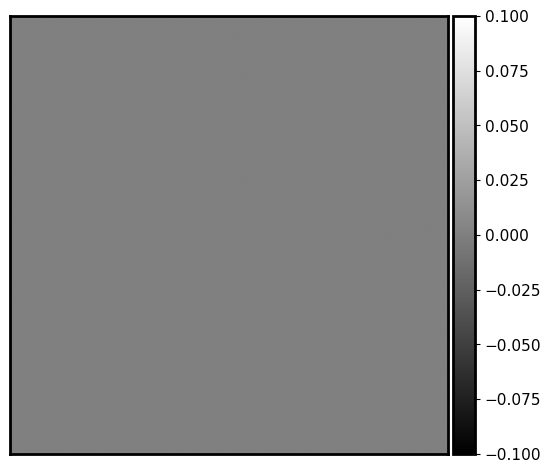

In [9]:
synthetic_image = np.zeros([500, 500])
show_image(synthetic_image, cmap='gray', show_colorbar=True, figsize=(6, 6))

## Generate calibration frames
### 2.1 Read-out noise

When we read out an image from a CCD, some small random noise is added to each pixel. This "read-out" noise follows a Gaussian distribution centered at zero. Typically you can find the "width" of this Gaussian in the CCD operating manual. For example, let's assume that the CCD manual said the read-out noise is `READ NOISE: 4e- rms` and the gain we used is `GAIN = 2 e- / ADU`. This means that the standard deviation of the read-out noise is 4 electron per read-out. Read noise of a CCD is almost always given in electrons, but images are typically in counts (ADUs). To convert electrons to counts (ADUs), we have to devide the number of electrons by gain (electrons per count). Therefore, the standard deviation of read-out noise in counts is 2. 

Below we write a function `read_noise` to generate the read-out noise to be added to the blank image that we generated above. Note that each time you run this function you'll get a different set of pixels so that it behaves like real noise.

```{margin}
Here we demonstrate how to write docstrings for a Python function. **It is always a good practice to write docstring for your code.** [Here](https://pandas.pydata.org/docs/development/contributing_docstring.html) is a nice guide to how to write good docstrings. GitHub copilot can also help you write docstrings (try it!)
```

In [10]:
def read_noise(image, amount, gain=2):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    image: numpy array
        To which we add the read noise. 
    amount : float
        The rms of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
        
    Returns
    -------
    noise: numpy array
        The read noise frame
    """
    shape = image.shape
    noise = np.random.normal(scale=amount / gain, size=shape)
    return noise

Text(0.5, 1.0, 'Read noise')

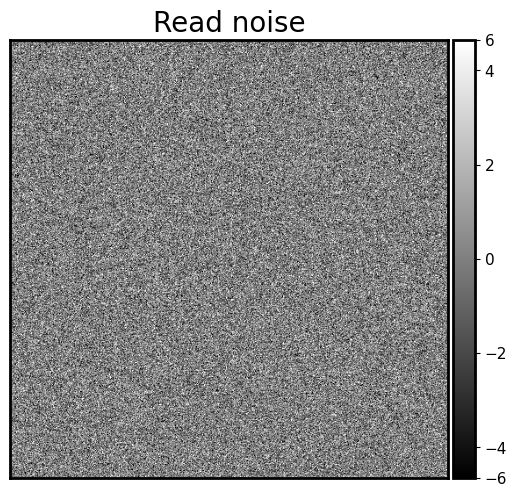

In [11]:
noise_im = synthetic_image + read_noise(synthetic_image, 4, gain=2)
fig = show_image(noise_im, cmap='gray', show_colorbar=True, figsize=(6, 6))
fig.set_title('Read noise', fontsize='20')

Nice! We get a beautiful noise image :) 

### 2.2 Bias

As we have already discussed in `Calibration Frames`, bias is a positive offset added to each pixel to make sure the counts are non-negative. If there is no this offset, as we see in the above image, some pixels are negative. 

As shown in `Calibration Frames`, the bias value is roughly the same across the CCD, but there is still some spatial patterns including "bad" columns. To model such a bias, we create a uniform array and add some "bad" columns (when you set `realistic=True`). Note that the bias is not a function of exposure time and does not have read-out noise. 

In [13]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    image: numpy array
        The image to which the bias will be added
    value: float
        Bias level to add, in counts.
    realistic : bool, optional
        If ``True``, add some "bad" columns with higher bias value
    
    Returns
    -------
    bias_im: numpy array
        The bias frame
    """
    shape = image.shape
    # This is the bias frame with the same bias value for all pixels
    bias_im = np.ones(shape) * value
    
    # Try to add "bad" columns
    if realistic:
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # not change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=0)
        number_of_colums = rng.randint(3, 9)
        
        # Randomly select which columns are bad
        columns = rng.randint(0, shape[1], size=number_of_colums)
        
        # This will add a little random-looking noise into the data.
        # This `col_pattern` is added to the global bias value to represent "bad" columns
        col_pattern = rng.randint(0, int(0.03 * value), size=shape[0])

        for c in columns:
            # Here `c` is the index of "bad" columns
            bias_im[:, c] = value + col_pattern
            
    return bias_im        

Text(0.5, 1.0, 'Bias alone, bad columns included')

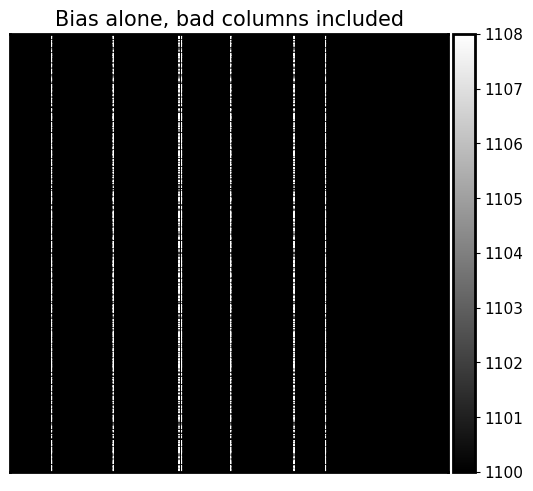

In [17]:
bias_only = bias(synthetic_image, 1100, realistic=True)
fig = show_image(bias_only, cmap='gray', show_colorbar=True, figsize=(6, 6))
fig.set_title('Bias alone, bad columns included', fontsize=15)

Now create realistic bias frame by adding bias and read noise together. **Note that we did not include any cosmic rays.**

Text(0.5, 1.0, 'Realistic bias frame')

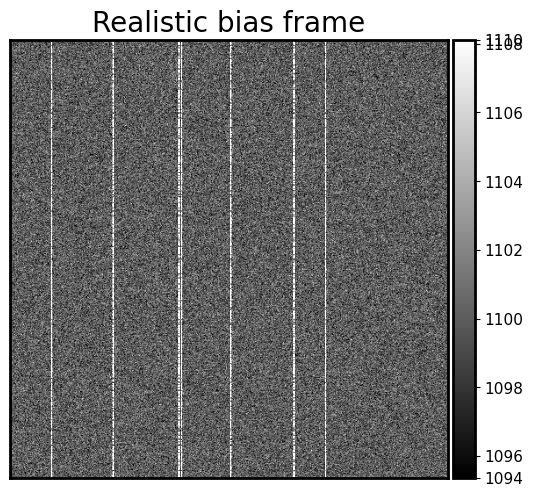

In [32]:
fig = show_image(noise_im + bias_only, cmap='gray', figsize=(6, 6), show_colorbar=True)
fig.set_title('Realistic bias frame', fontsize=20)

### 2.3 Dark frame

For modern cooled CCD, the dark current is typically very small (0.1 electrons/pixel/second or less). 
Dark counts in the function below are calculated by multiplying the dark current by the exposure time
after converting the dark current unit from electrons to counts using the gain. Notice that the dark counts follow a Poisson distribution. So it will look noisy. 

However, as we seen in `Calibration Frames`, some pixels as "hot" pixels. Their dark current is much larger than the other pixels. 

The function below simulates dark current only, i.e. it does *not* simulate the
read noise that is a part of any actual dark frame from a CCD.


In [20]:
def dark_current(image, current, exposure_time, gain=2, hot_pixels=True):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    image : numpy array
        The image array used to determine the shape of the dark frame.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    hot_pixels : bool, optional
        Whether to include hot pixels or not.
    
    Returns
    -------
    dark_im: numpy array
        The dark frame, without read noise and bias
    """
    # dark current for every pixel. Real dark counts follow 
    # a Poisson distribution with lambda = base_current.
    base_current = current * exposure_time / gain
    dark_im = np.random.poisson(base_current, size=image.shape)
    
    if hot_pixels:
        n_hot = np.random.randint(5, 50) # number of hot pixels
        y_max, x_max = dark_im.shape
        
        # For a given CCD, the positions of hot pixels are not changing. 
        # So we set a random number seed to ensure we get the same hot pixels every time. 
        rng = np.random.RandomState(seed=0)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = base_current * 100 # 100 times hotter than the base dark current
        dark_im[(hot_y, hot_x)] = hot_current
    
    return dark_im

Text(0.5, 1.0, 'Dark current only, 0.1 $e^-$/sec/pix\n900 sec exposure')

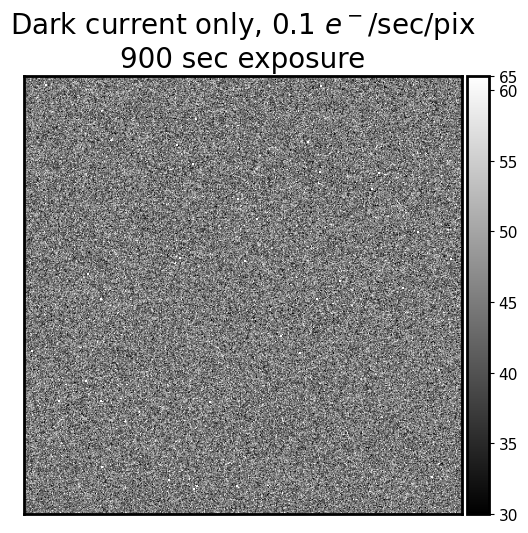

In [22]:
dark_exposure = 900
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)

fig = show_image(dark_only, cmap='gray', figsize=(6, 6), show_colorbar=True)
title_string = f'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'
fig.set_title(title_string, fontsize=20)

Realistic dark frame is a combination of all of them: bias-only, read-out noise, and dark-only

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

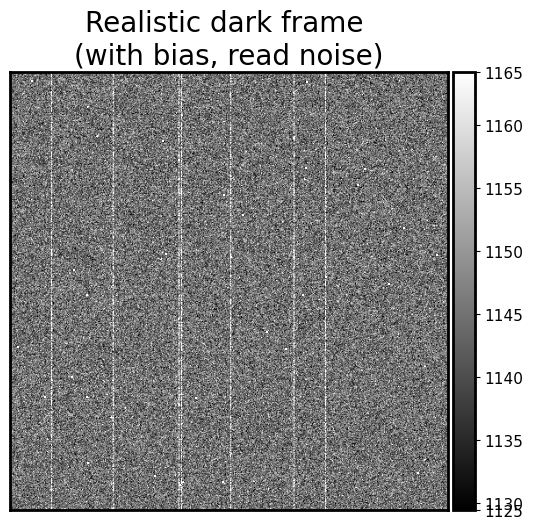

In [23]:
fig = show_image(dark_only + bias_only + noise_im, cmap='gray', figsize=(6, 6), show_colorbar=True)
fig.set_title('Realistic dark frame \n(with bias, read noise)', fontsize=20)

It looks quite real! However, we did not include any cosmic rays and flat field.

### 2.4 Sky background

The amount of sky background depends on the atmospheric conditions (humidity, presence of light clouds, etc.), the light sources in the sky (the Moon) and lights from the surrounding area. It may or may not be uniform across the field of view. The [sky brightness on Mauna Kea](https://iopscience.iop.org/article/10.1086/133993) in the V band is $\mu_V \approx 21.5\ \mathrm{mag/arcsec}^2$.

The function below generates a homogeneous sky background in the field of view. The photons from sky background also follow a Poisson distribution. The sky counts also scales with exposure time. 

```{margin}
Question: if the argument `sky_counts` is in counts, why do we need `gain` in this function? 
```

In [24]:
def sky_background(image, sky_counts_per_sec, exposure_time, gain=2):
    """
    Generate a flag sky background.
    
    Parameters
    ----------
    image : numpy array
        The input image. Only its shape is used. 
    sky_counts_per_sec : float
        The target value for the number of counts per second from the sky.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
        
    Returns
    -------
    sky_im : numpy array
        The simulated image for the sky background. 
    """
    sky_im = np.random.poisson(sky_counts_per_sec * gain * exposure_time, size=image.shape) / gain
    return sky_im

Text(0.5, 1.0, 'Sky background only, 0.5 counts input')

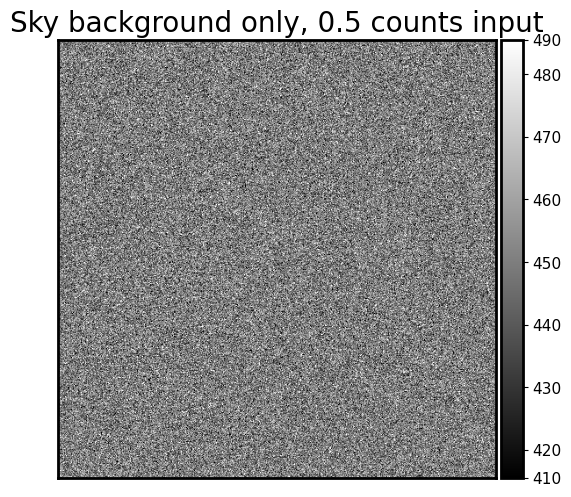

In [25]:
sky_level = 0.5 # counts per sec
sky_only = sky_background(synthetic_image, sky_level, exposure_time=900, gain=2)

fig = show_image(sky_only, cmap='gray', figsize=(6, 6), show_colorbar=True)
fig.set_title(f'Sky background only, {sky_level} counts input', fontsize=20)

Nice! Let's combine `sky_only` with dark current, bias, and read-out noise to make our "sky" more realistic. This is how the image of clouds look like. 

Text(0.5, 1.0, 'Sky, dark, bias, and read noise')

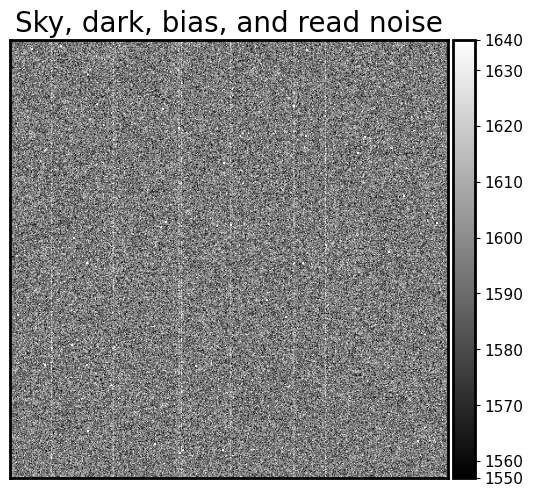

In [26]:
fig = show_image(sky_only + dark_only + bias_only + noise_im, 
                 cmap='gray', figsize=(6, 6), show_colorbar=True)
fig.set_title('Sky, dark, bias, and read noise', fontsize=20)

### 2.5 Signal-to-noise ratio

As we already learned from `Basic Statistics` and the above cells, the counts from astronomical objects, sky background, and dark current all follow Poisson distribution. Let's now take a look at the the signal-to-noise ratio and how that scales with the exposure time. In the exercise below, we simply study the signal on one pixel. The signal comes from a star (with `star_flux` in `e-/s`), the sky background (`sky_flux`, in `e-/s`), and readout noise (`sigma_read`, in `e-`).

In [61]:
# Let's assume the following values:
star_flux = 20 # e- / s
sky_flux = 0.5 # e- / s
sigma_read = 4 # e- / s
t_exp = 1 # s

Now let's see what's the total signal we receive on this pixel:
```python
star_signal = star_flux * t_exp
sky_signal = sky_flux * t_exp
read_signal = 0

total_signal = star_signal + sky_signal + read_signal
```
We note that the readout noise doesn't contribute to the signal, since the average value of the readout noise is zero. However, it contributes to the "noise". The noises from sky and star are all Poisson. Because these noises are independent, we can add the standard deviations in quadrature:
```python
star_noise = np.sqrt(star_signal)
sky_noise = np.sqrt(sky_signal)
read_noise = sigma_read

total_noise = np.sqrt(star_noise**2 + sky_noise**2 + read_noise**2)
```

Now we can define the **signal-to-noise ratio**:
```python
SNR = total_signal / total_noise
```

Let's see what's the SNR for the above situation:

In [62]:
star_signal = star_flux * t_exp
sky_signal = sky_flux * t_exp
read_signal = 0

total_signal = star_signal + sky_signal + read_signal

star_noise = np.sqrt(star_signal)
sky_noise = np.sqrt(sky_signal)
read_noise = sigma_read

total_noise = np.sqrt(star_noise**2 + sky_noise**2 + read_noise**2)

SNR = total_signal / total_noise
print(f"SNR = {SNR}")

SNR = 3.3931841432697087


Great! This means that the star's signal is about 3 times brighter than the noise. A `SNR=3` detection is not so great. What if we increase the exposure time?

In [63]:
t_exp = 10 # s

star_signal = star_flux * t_exp
sky_signal = sky_flux * t_exp
read_signal = 0

total_signal = star_signal + sky_signal + read_signal

star_noise = np.sqrt(star_signal)
sky_noise = np.sqrt(sky_signal)
read_noise = sigma_read

total_noise = np.sqrt(star_noise**2 + sky_noise**2 + read_noise**2)

SNR = total_signal / total_noise
print(f"SNR = {SNR}")

SNR = 13.789792276924405


Now the SNR is much higher and it means that we are very confident about detecting this star over noise. Now you can solve the following exercises:

```{admonition} Exercise
1. Write the above code of calculating SNR to a function, like the following:

```python
def calc_SNR(star_flux, sky_flux, sigma_read, t_exp):
    ### Your answer here ###

    return SNR
```

2. Using this function, calculate the SNR of the star when the exposure time is in `t_exps = np.linspace(1, 200, 50)`. Plot the SNR as a function of exposure time. What's the best functional form to describe this relation? (Hint: you can plot the `SNR-texp` relation in `loglog` scale.)

3. For this star, if you wanna double the SNR, should you also double the exposure time? Or triple the exposure time?

4. For a faint source with a short exposure time, what dominates the SNR (sky or read noise)?
```

## 3. Add some real stars

The images that we generated look quite boring so far. Shall we add some stars to it? Let's do it.

In order to make it look very realistic, we prepared [a catalog](../_static/ObsAstroData/simulate_star_cat.fits) containing 307 stars around `RA = 280 deg, Dec = 0 deg` from the [Gaia mission](https://www.esa.int/Science_Exploration/Space_Science/Gaia_overview). The catalog has the `RA`, `Dec`, and the g-band flux (`g_flux` in electron/sec) of each star. There are three more things to do before we can inject these stars to the image:

- We have to convert the sky coordinates `(RA, Dec)` of stars to image coordinates `(x, y)`. This can be done using [**"World Coordinate System (WCS)"**](https://docs.astropy.org/en/stable/wcs/). We build a `wcs` instance standing for the imaginary telescope we're using. Then we use this `wcs` to calculate image coordinates of the stars.

- We need to convert the flux in electron per second to counts given the gain and exposure time. This is easy: `counts = g_flux / gain * exposure_time`.

- Stars are not a single point on the image. Instead, they are blobs, due to the **Point Spread Function (PSF)** of the optical system (including the atmosphere). Therefore, we need to build a PSF according to the seeing and scale this PSF to match the total counts of each star. 

We will solve these problems one by one. We read the star catalog first. Again, `g_flux` is in electron / sec.

In [33]:
from astropy.table import Table
cat = Table.read('./simulate_star_cat.fits')
cat[:5]

<Table length=5>
        ra                  dec             g_flux 
       deg                  deg                    
     float64              float64          float32 
------------------ ---------------------- ---------
280.00182067676167 -0.0006054995504625365 1.5633024
280.00291787552493   0.001124410381860149 0.5670684
 280.0004310363741  -0.003360890132438791 0.2738112
280.00533847454955  0.0009738996826714352 0.5869863
279.99457484780316 -0.0020924098806938255 0.2795567

### 3.1 WCS and image coordinates

WCS is nicely introduced [here](https://docs.astropy.org/en/stable/wcs/). We assume that our "telescope" has a pixel scale of 0.5 arcsec / pixel, and assume the field of view has no distorion. 

In [34]:
from astropy import wcs

pixel_scale = 0.5 # arcsec / pix

shape = synthetic_image.shape
# Create a new WCS object.  The number of axes must be set from the start
w = wcs.WCS(naxis=2)

# Pixel coordinate of reference point. 
# We set the ref point to be the center of the image.
w.wcs.crpix = [shape[1]/2, shape[0]/2] 

# This is the coordinate increment (in deg) at reference point
w.wcs.cdelt = np.array([-pixel_scale / 3600, pixel_scale / 3600])

# This is the RA, Dec of the reference point
w.wcs.crval = [280, 0]

# This is the projection type. 
# Since our FOV is quite small, this doesn't matter that much.
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [47]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 280.0  0.0  
CRPIX : 250.0  250.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888888889  0.0001388888888888889  
NAXIS : 0  0

We can use the function `wcs_world2pix` to convert sky coordinates to pixel coordinates.

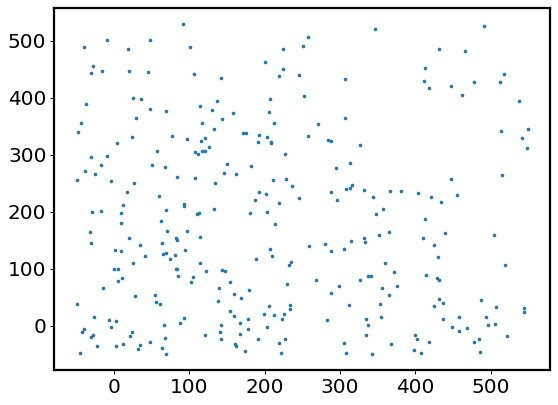

In [48]:
xs, ys = w.wcs_world2pix(cat['ra'], cat['dec'], 0)
plt.scatter(xs, ys, s=5)

### 3.2 Point Spread Function (PSF)

This is actually a huge topic. Maybe I should write another notebook on this. 

We use a Gaussian function to describe the PSF of the "telescope" we use, although the PSF of real telescopes is not precisely Gaussian. The Gaussian function in 2-D is:  $f(x, y) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2}\left[(x - x_0)^2 + (y - y_0)^2\right]}$. This is a normalized Gaussian function, i.e., $\int_x \int_y f(x,y)=1$. Although you can write your own implementation, we use [`astropy.modeling.functional_models.Gaussian2D`](https://docs.astropy.org/en/latest/api/astropy.modeling.functional_models.Gaussian2D.html#astropy.modeling.functional_models.Gaussian2D) for convenience. As you may notice, for a normalized Gaussian, the amplitude in `Gaussian2D` should be $\frac{1}{2\pi \sigma^2}$. 

We know that the width of a Gaussian is described by $\sigma$. In astronomy, the width of the PSF is often described by its [Full Width at Half Maximum (FWHM)](https://en.wikipedia.org/wiki/Full_width_at_half_maximum). For a Gaussian function with $\sigma$, its FWHM is $2\sqrt{2\ln 2} \sigma \approx 2.355 \sigma$. 

Below we show how to inject a normalized Gaussian PSF (i.e., **a star whose total count = 1**) to an image.

In [35]:
from astropy.modeling.functional_models import Gaussian2D
psf = Gaussian2D()
seeing = 1.5 # arcsec, FWHM of the PSF
sigma = seeing / 2.355 / pixel_scale # sigma of the Gaussian, in pixel

# To evaluate the PSF, we needs a grid of coordinates
# This can be generated using `np.mgrid`
shape = synthetic_image.shape
y, x = np.mgrid[:shape[1], :shape[0]]

single_star = psf.evaluate(x, y,
                           amplitude=1 / (2 * np.pi * sigma**2),
                           x_mean=250, y_mean=250,
                           x_stddev=sigma, y_stddev=sigma, theta=0)

```{margin}
You can try to plot `np.log10(single_star)`. What happens?
```

1.0000000000000488


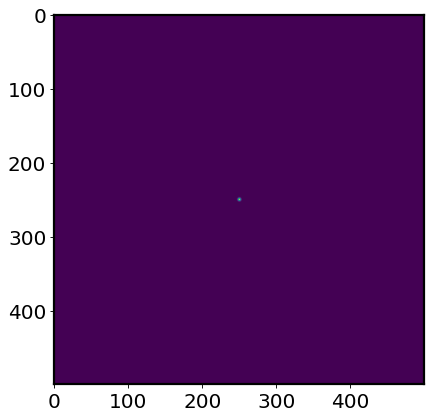

In [36]:
print(np.sum(single_star))
plt.imshow(single_star)
# yeah... a tiny dot. 

### 3.3 Let's cook!

We have all the ingredients! Let's glue the above snippets together and write a function to inject stars from the catalog. Please note how we calculate counts from `g_flux` and how we sample the Poisson distributions.

A reminder: the final image is:
$$
\text{Image = stars + sky + dark + bias + readnoise}
$$

In [51]:
def inject_stars(image, star_cat, w, exposure_time=900, gain=2, seeing=1.5):
    """
    Inject stars to the input image
    
    Parameters
    ----------
    image : numpy array
        The input image whose shape will be used to generate the output image.
    star_cat : astropy table
        The catalog of stars to be injected. Must contain columns of 'ra', 'dec', 'g_flux'.
        `g_flux` is the flux of the star in the g-band in units of electron / sec.
    w : astropy.wcs.WCS
        The WCS of the input image.
    exposure_time : float, optional
        Exposure time of the image, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    seeing: float. 
        FWHM of the PSF, in arcsec.
    
    Returns
    -------
    stars_real : numpy array
        The image with stars injected.
    """
    shape = image.shape
    sigma = seeing / 2.355 / pixel_scale 
    # sigma of the Gaussian, in pixel
    
    # Convert (RA, Dec) of stars to (x, y) based on the WCS info
    xs, ys = w.wcs_world2pix(star_cat['ra'], star_cat['dec'], 0)
    # These are the coordinates of each pixel of the image
    y, x = np.mgrid[:shape[1], :shape[0]]
    
    # Initialize the PSF
    psf = Gaussian2D()
    
    # Again, the counts should follow a Poisson distribution
    # We first build an image showing the mean of this Poisson distribution
    # Then sample the distribution
    counts = star_cat['g_flux'] / gain * exposure_time
    
    # Initialize an empty image
    stars_img = np.zeros_like(image)
    
    # Loop over stars
    for i, count in enumerate(counts):
        stars_img += psf.evaluate(x, y, 
                                  amplitude=count / (2 * np.pi * sigma**2), 
                                  x_mean=xs[i], y_mean=ys[i],
                                  x_stddev=sigma, y_stddev=sigma, theta=0)
    
    # Sample from Poisson based on the mean counts
    stars_real = np.random.poisson(lam=stars_img)
    
    return stars_real

Text(0.5, 1.0, 'Stars only')

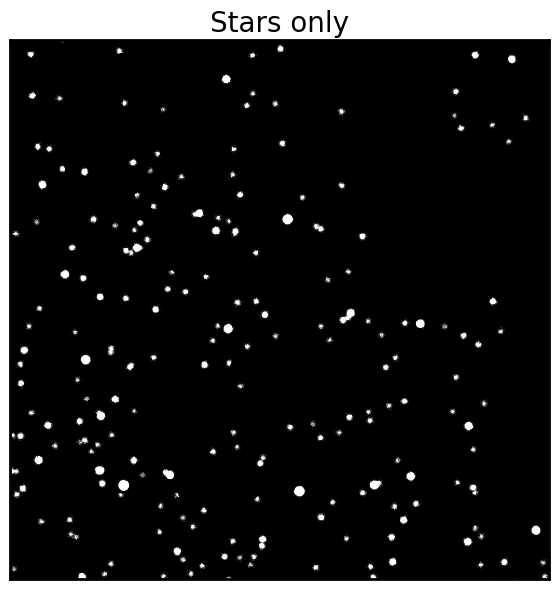

In [40]:
stars_only = inject_stars(synthetic_image, cat, w, 
                          exposure_time=900, gain=2, seeing=1.5)
fig = show_image(stars_only, cmap='gray', figsize=(7, 7))
fig.set_title('Stars only', fontsize=20)

Text(0.5, 1.0, 'Realistic image at RA = 280 deg, Dec = 0 deg \n exptime = 900 s')

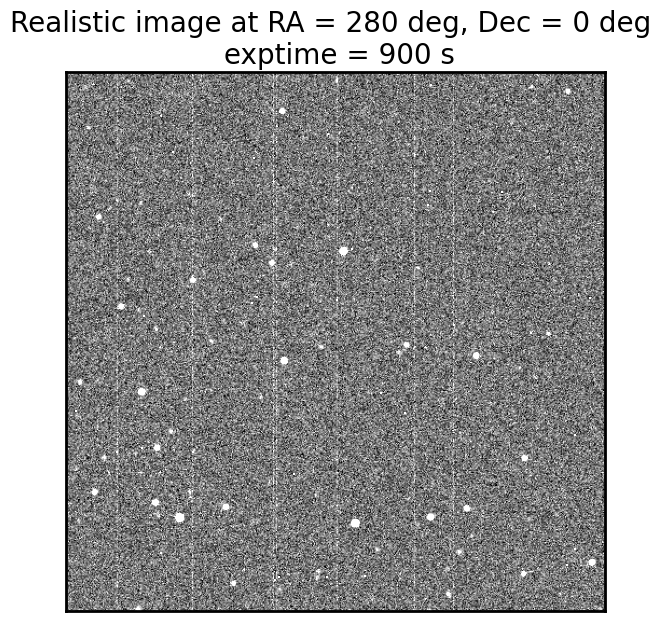

In [41]:
# Add everything together
realistic_img = stars_only + sky_only + dark_only + bias_only + noise_im
fig = show_image(realistic_img, cmap='gray', figsize=(7, 7))

fig.set_title('Realistic image at RA = 280 deg, Dec = 0 deg \n exptime = 900 s', fontsize=20)

### Interactive demo

You can play with different combinations of all parameters. Change each of them independently to build intuition on how these parameters affect the final image. You might have to wait a few seconds each time you change the parameters. 

```{note}
This does not run directly on this website. You can download the notebook and run it locally, or run it on Google Colab. **It might be quite slow (depending on your machine)**.

``````

In [ ]:
%matplotlib inline

from ipywidgets import interactive, interact

@interact(bias_level=(1000, 1200, 10), 
          dark=(0.01, 1, 0.01), 
          sky_counts_per_sec=(0, 3, 0.1),
          gain=(0.5, 3.0, 0.1), 
          read=(0, 50, 2.0),
          exposure=(100, 1200, 100),
          seeing=(0.5, 3, 0.5)
         )


def complete_image(bias_level=1100, read=10.0, gain=1, dark=0.1, 
                   exposure=300, sky_counts_per_sec=0.3, 
                   seeing=1.5):
    synthetic_image = np.zeros([500, 500])
    show_image(synthetic_image + 
               read_noise(synthetic_image, read, gain) +
               bias(synthetic_image, bias_level, realistic=True) + 
               dark_current(synthetic_image, dark, exposure, gain) +
               sky_background(synthetic_image, sky_counts_per_sec, exposure, gain) +
               inject_stars(synthetic_image, cat, w, exposure, gain, seeing),
               cmap='gray',
               figsize=(6, 6))
    
i = interactive(complete_image, 
                bias_level=(1000, 1200, 10), 
                dark=(0.01, 1, 0.01), 
                sky_counts_per_sec=(0, 3, 0.1),
                gain=(0.5, 3.0, 0.1), 
                read=(0, 50, 2.0),
                exposure=(100, 1200, 100),
                seeing=(0.5, 3, 0.5)
                )

for kid in i.children:
    try:
        kid.continuous_update = False
    except KeyError:
        pass

---

## Discussion: Data generating process

Symbolically, we simulate our "realistic" image using the following recipe. For a given pixel, the final count is

$
X_{\text{image}} = \text{bias} + X_{\text{read noise}} + X_{\text{dark current}} + X_{\text{sky}} + X_{\text{stars}}
$

Variables denoted as $X_{?}$ are random variables -- these quantities will change if you generate them again. 

- $\text{bias}$ is a constant offset. Although it has pixel-to-pixel variation. 
- $X_{\text{read noise}} \sim \mathcal{N}(0, \sigma_{\text{read}}^2)$ is a Gaussian noise
- $X_{\text{dark current}} \sim \mathcal{P}\text{oisson}\,(\lambda_{\text{dark}})$ follows a Poisson distribution.  $\lambda_{\text dark}$ should be in counts. If not, please use `gain` to convert it to counts.
- $X_{\text{sky}} \sim \mathcal{P}\text{oisson}\,(\lambda_{\text{sky}})$. Similar to dark current. 
- $X_{\text{star}} \sim \mathcal{P}\text{oisson}\,(\lambda_{\text{star}})$. Similar to dark current and sky background. 


Therefore, the "noise level" in the final image depends on $\sigma_{\text{read}}, \lambda_{\text{dark}}, \lambda_{\text{sky}}, \lambda_{\text{star}}$. 


Extracting the science photons (i.e. the stars) is in principle a matter of subtraction:
$
X_{\text{stars}} = X_{\text{image}} - \text{bias} - X_{\text{dark current}} - X_{\text{sky}} + X_{\text{read noise}}
$

As we showed in [this notebook](./calibration_frame.ipynb), read noise can be reduced by stacking lots of images. 

Also, we have ignored flat fielding throughout this notebook. When considering it, we have 
$
X_{\text{image}} = \text{bias} + X_{\text{read noise}} + X_{\text{dark current}} + \text{flat} * (X_{\text{sky}} + X_{\text{stars}}).
$
Flat fielding is a multiplicative effect. 


## Homework

```{admonition} Homework
- Does a dark frame also have a bias level? If so, how can we correct for this?
- Load all dark frames in `./calibration_frames/dark`, subtract the master bias frame from each dark frame, and then combine them to make a master dark frame. Try different combining methods (mean, median, sigma-clipping) and compare the results.
```

In [50]:
np.median(bias_only), np.median(noise_im), np.median(sky_only)

(1100.0, 0.002896702918170552, 450.0)

In [52]:
im = realistic_img - np.median(bias_only) - np.median(noise_im) - np.median(sky_only)

<Axes: >

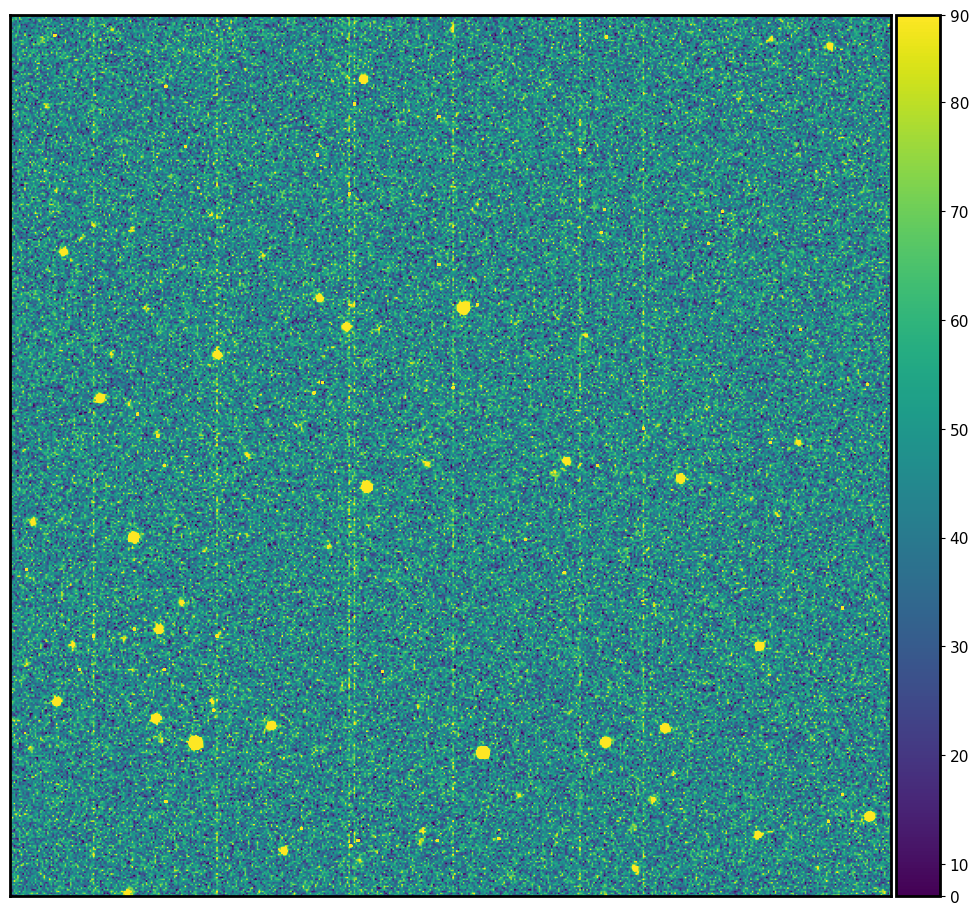

In [54]:
show_image(im, show_colorbar=True)

----